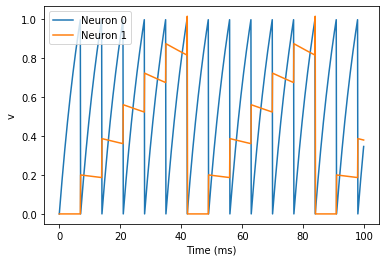

In [3]:
from brian2 import *
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''

G=NeuronGroup(2,eqs,threshold="v>1",reset="v=0",method="exact")
G.I = [2, 0]  # I is the driving current
G.tau = [10, 100]*ms

S = Synapses(G, G, on_pre='v_post += 0.2') # (source,target)=(G,G)
# when a spike occurs in the presynaptic neuron (hence on_pre) it causes an instantaneous change to happen
# v_post += 0.2
# in this line we have only defined the synapse model, we haven’t actually created any synapses
S.connect(i=0, j=1)  #create a synapse 
#i refers to the source neuron index, and j to the target neuron index

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();


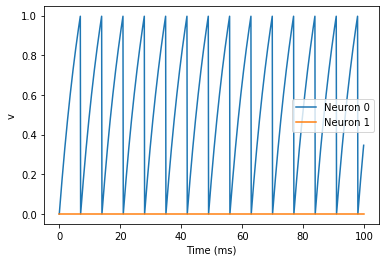

In [4]:
                                     # without synaps
start_scope()
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G=NeuronGroup(2,eqs,threshold="v>1",reset="v=0",method="exact")
G.I = [2, 0]
G.tau = [10, 100]*ms
#S = Synapses(G, G, on_pre='v_post += 0.2')
#S.connect(i=0, j=1)
M = StateMonitor(G, 'v', record=True)
run(100*ms)
plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();


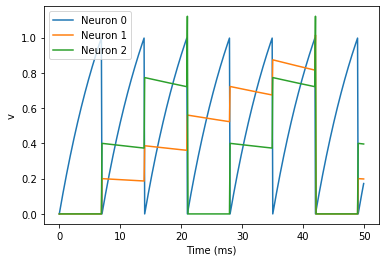

In [9]:
# synaptic weight variable w
start_scope()
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w') #each synapse can behave differently depending on the value of w
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

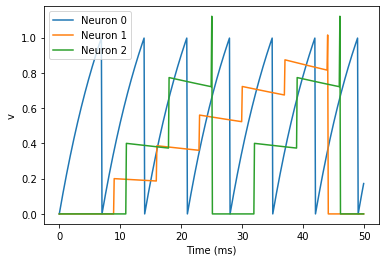

In [10]:
#Introducing a delay
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

In [21]:
#More complex connectivity
start_scope()
N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)
#as long as i!=j, it will connect neurons i and j with probability 0.2 

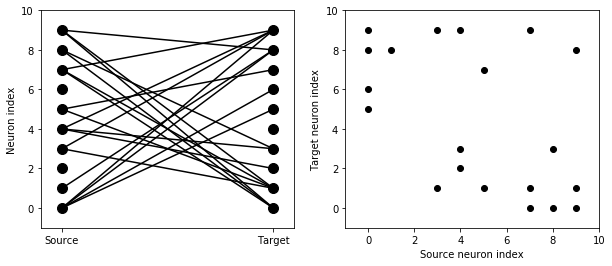

In [22]:
# VISUALISATION ************************************************************************************************
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(S)

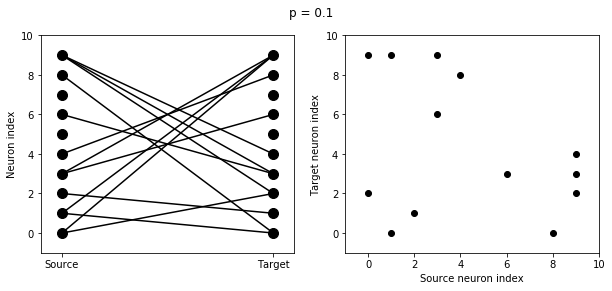

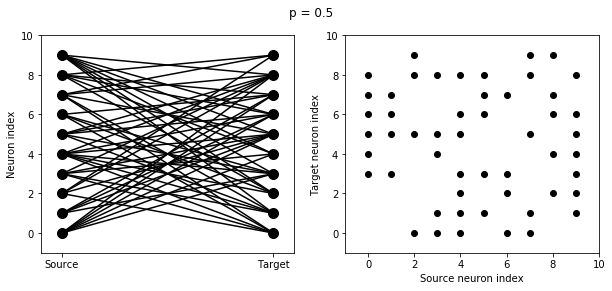

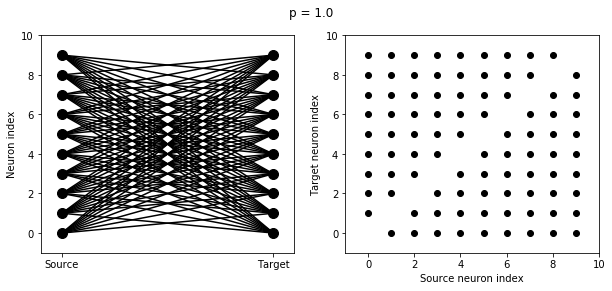

In [15]:
# CHANGING P
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))

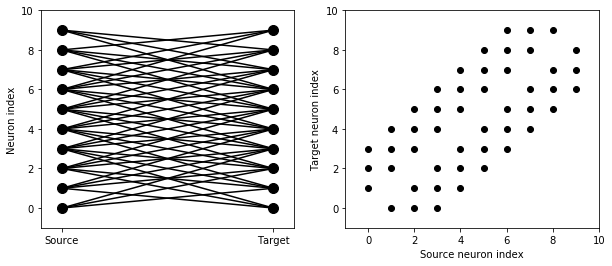

In [26]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='abs(i-j)<4 and i!=j')
visualise_connectivity(S)

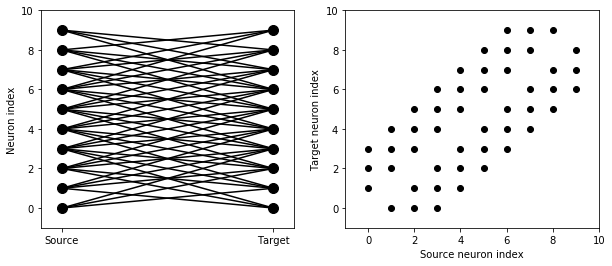

In [27]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='k for k in range(i-3, i+4) if i!=k', skip_if_invalid=True)
visualise_connectivity(S)


In [ ]:
#have a distance-dependent connectivity function